## Montagem do Kernell

Importações e Configurações Iniciais

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # Para o Q-Q plot
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore') # Para ignorar warnings que não interrompem a execução


In [ ]:
# Configurações para melhor visualização
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

 Carregamento dos Dados

In [ ]:
0csv_path = '/content/drive/MyDrive/PEMcell/dados_PEMcell(COMPLETA).csv'
dados = pd.read_csv(csv_path, sep=';')

## Recorte de dados

In [ ]:
# Exibir as primeiras linhas e informações para verificar o carregamento
print("Dimensões dos dados:", dados.shape)
print("Primeiras 5 linhas:")
print(dados.head())
print("\nInformações sobre os dados:")
dados.info()
print("\nEstatísticas Descritivas:")
print(dados.describe())

# --- Correção dos nomes das colunas conforme o CSV ---
# Verificar valores únicos em colunas categóricas ou de ID
print("\nValores únicos em 'set':", dados['set'].unique())
print("\nValores únicos em 'type':", dados['type'].unique())

Dimensões dos dados: (43259, 22)
Primeiras 5 linhas:
                                           test_name         type  cathalyst_loading 1  cathalyst_loading 2  set  z_real   z_img  applied_voltage    OCV    MPD      R  R_at_0.5V  i_at_0.8V  i_at_0.5V  i_at_0.3V  current_density  cell_voltage  power_density  pressure  relative_humidity  membrane_compression  nafion_percent
0         Activation Test MEA Constant Current 0.25A  Impedance 1                 0.38                 0.38  1.0   0.121  0.0173              0.3  968.0  215.0  142.0        NaN        NaN        NaN        NaN              NaN           NaN            NaN       NaN                NaN                   NaN             NaN
1  Activation Test MEA Constant Current 0.25A\t\t...  Impedance 1                 0.38                 0.38  1.0   0.125  0.0128              0.3  968.0  215.0  142.0        NaN        NaN        NaN        NaN              NaN           NaN            NaN       NaN                NaN              

Pré-processamento e Limpeza de Dados

In [ ]:
# Criar uma cópia para evitar SettingWithCopyWarning
dados_processados = dados.copy()

In [ ]:
# Calcular a fração de valores nulos
null_fractions = dados_processados.isnull().sum() / len(dados_processados)
print("\nFração de valores nulos por coluna:")
print(null_fractions[null_fractions > 0].sort_values(ascending=False))


Fração de valores nulos por coluna:
nafion_percent          0.984928
R_at_0.5V               0.971960
i_at_0.8V               0.971960
membrane_compression    0.971960
cell_voltage            0.884302
current_density         0.884302
power_density           0.884302
i_at_0.3V               0.878430
i_at_0.5V               0.877783
set                     0.518505
pressure                0.481495
relative_humidity       0.481495
R                       0.467371
OCV                     0.467371
MPD                     0.439331
z_real                  0.115698
applied_voltage         0.115698
z_img                   0.115698
cathalyst_loading 1     0.028040
cathalyst_loading 2     0.028040
dtype: float64


In [ ]:
# Colunas a serem descartadas baseadas na análise inicial do seu notebook
colunas_para_descartar = [
    'test_name', 'z_real', 'z_img', 'applied_voltage',
    'R_at_0.5V', 'i_at_0.8V', 'membrane_compression', 'nafion_percent'
]

dados_processados = dados_processados.drop(columns=colunas_para_descartar, errors='ignore')


In [ ]:
# Remover linhas onde 'current_density' é NaN, pois é uma feature central
dados_processados.dropna(subset=['current_density'], inplace=True)

In [ ]:
dados_processados.shape
dados_processados.info()
dados_processados.describe()
dados_processados.head()


<class 'pandas.core.frame.DataFrame'>
Index: 5005 entries, 38254 to 43258
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   type                 5005 non-null   object 
 1   cathalyst_loading 1  3792 non-null   float64
 2   cathalyst_loading 2  3792 non-null   float64
 3   set                  1580 non-null   float64
 4   OCV                  3792 non-null   float64
 5   MPD                  5005 non-null   float64
 6   R                    3792 non-null   float64
 7   i_at_0.5V            2768 non-null   float64
 8   i_at_0.3V            2740 non-null   float64
 9   current_density      5005 non-null   float64
 10  cell_voltage         5005 non-null   float64
 11  power_density        5005 non-null   float64
 12  pressure             3425 non-null   float64
 13  relative_humidity    3425 non-null   float64
dtypes: float64(13), object(1)
memory usage: 586.5+ KB


,type,cathalyst_loading 1,cathalyst_loading 2,set,OCV,MPD,R,i_at_0.5V,i_at_0.3V,current_density,cell_voltage,power_density,pressure,relative_humidity
38254,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,2550.0,0.296,755.0,5.0,30.0
38255,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,2380.0,0.345,821.0,5.0,30.0
38256,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,2180.0,0.395,859.0,5.0,30.0
38257,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,1950.0,0.446,867.0,5.0,30.0
38258,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,1690.0,0.495,839.0,5.0,30.0


In [ ]:
dados_processados

,type,cathalyst_loading 1,cathalyst_loading 2,set,OCV,MPD,R,i_at_0.5V,i_at_0.3V,current_density,cell_voltage,power_density,pressure,relative_humidity
38254,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,2550.0,0.296,755.0,5.0,30.0
38255,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,2380.0,0.345,821.0,5.0,30.0
38256,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,2180.0,0.395,859.0,5.0,30.0
38257,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,1950.0,0.446,867.0,5.0,30.0
38258,Polarization 1.a,0.38,0.38,NaN,996.0,869.0,64.0,1500.0,2500.0,1690.0,0.495,839.0,5.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43254,"Various Membrane Compression, Various RHC",NaN,NaN,NaN,NaN,625.0,NaN,900.0,1300.0,1160.0,0.383,445.0,25.0,100.0
43255,"Various Membrane Compression, Various RHC",NaN,NaN,NaN,NaN,625.0,NaN,900.0,1300.0,1250.0,0.334,416.0,25.0,100.0
43256,"Various Membrane Compression, Various RHC",NaN,NaN,NaN,NaN,625.0,NaN,900.0,1300.0,1340.0,0.284,379.0,25.0,100.0
43257,"Various Membrane Compression, Various RHC",NaN,NaN,NaN,NaN,625.0,NaN,900.0,1300.0,1420.0,0.234,332.0,25.0,100.0


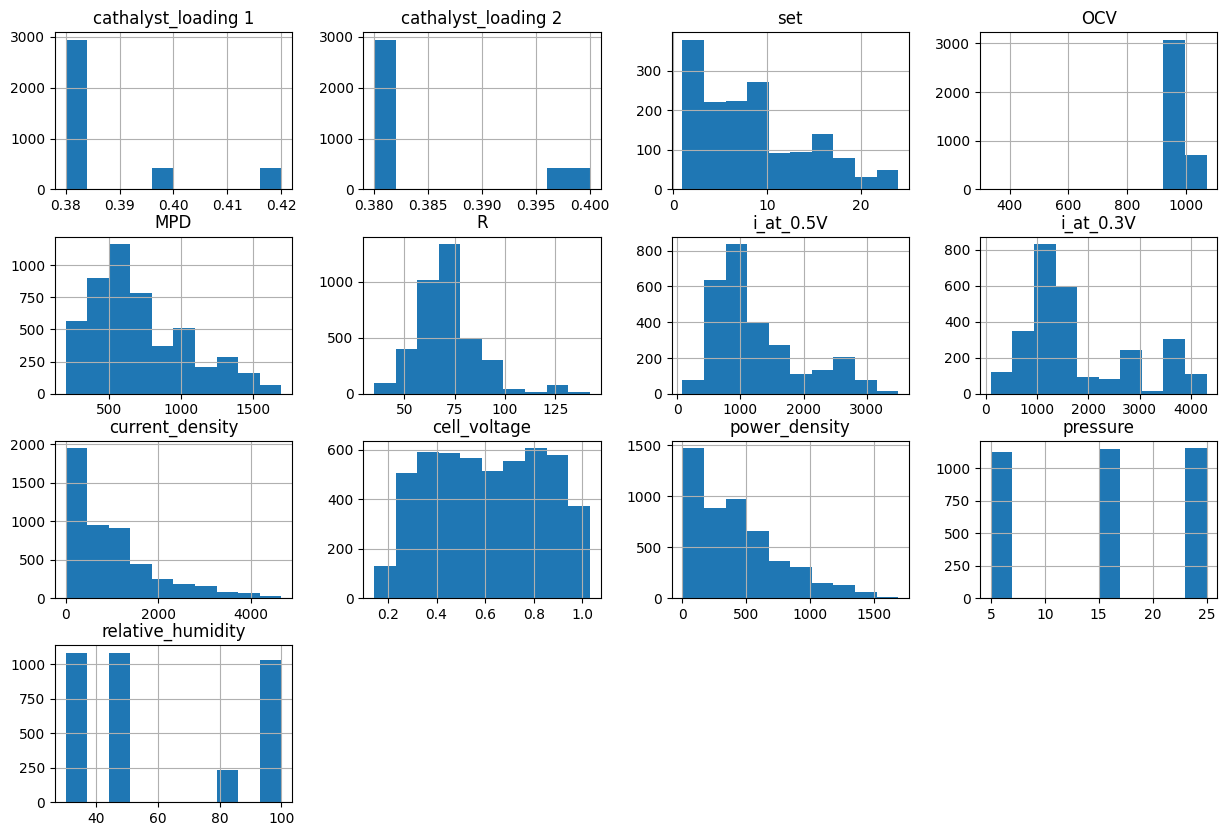

In [ ]:
# Visualizar a distribuição dos dados após o pré-processamento (opcional)
dados_processados.hist(figsize=(15, 10))
plt.show()

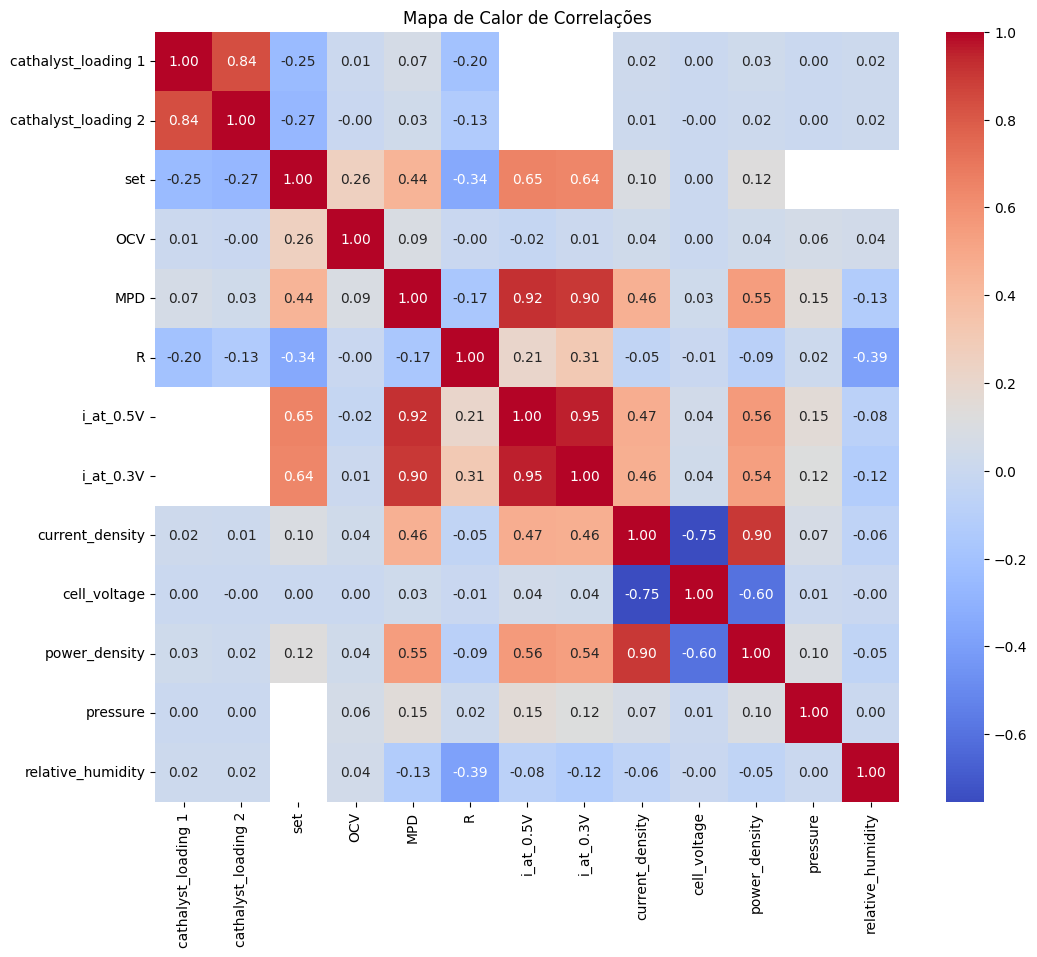

In [ ]:
# Visualizar correlações
plt.figure(figsize=(12, 10))

# Select only numerical columns for correlation calculation
numerical_dados_processados = dados_processados.select_dtypes(include=np.number)

sns.heatmap(numerical_dados_processados.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlações')
plt.show()

In [ ]:
dados_processados['power_density'].describe()

,power_density
count,5005.000000
mean,421.568894
std,341.575833
min,0.000000
25%,118.000000
50%,365.000000
75%,603.000000
max,1690.000000


In [ ]:
dados_processados['current_density'].describe()

,current_density
count,5005.000000
mean,956.037968
std,933.433492
min,0.000000
25%,156.000000
50%,734.000000
75%,1360.000000
max,4650.000000


## Criação de variável

Engenharia de Feature: Criar a variável de saída 'cell_power_product'

In [ ]:
# Engenharia de Feature: Criar a variável de saída 'cell_power_product'
if 'cell_voltage' in dados_processados.columns and 'power_density' in dados_processados.columns:
    dados_processados['cell_power_product'] = dados_processados['cell_voltage'] * dados_processados['power_density']
else:
    print("WARNING: 'cell_voltage' ou 'power_density' não encontradas para criar 'cell_power_product'. Verifique os dados.")


In [ ]:
# Exibir o shape após o pré-processamento
print("\nDimensões dos dados após pré-processamento inicial:", dados_processados.shape)
print("\nInformações sobre os dados processados:")
print(dados_processados.info())


Dimensões dos dados após pré-processamento inicial: (5005, 15)

Informações sobre os dados processados:
<class 'pandas.core.frame.DataFrame'>
Index: 5005 entries, 38254 to 43258
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   type                 5005 non-null   object 
 1   cathalyst_loading 1  3792 non-null   float64
 2   cathalyst_loading 2  3792 non-null   float64
 3   set                  1580 non-null   float64
 4   OCV                  3792 non-null   float64
 5   MPD                  5005 non-null   float64
 6   R                    3792 non-null   float64
 7   i_at_0.5V            2768 non-null   float64
 8   i_at_0.3V            2740 non-null   float64
 9   current_density      5005 non-null   float64
 10  cell_voltage         5005 non-null   float64
 11  power_density        5005 non-null   float64
 12  pressure             3425 non-null   float64
 13  relative_humidity    3425 non-nul

## Análise Exploratória

Análise Bivariada - Correlação

<Axes: >

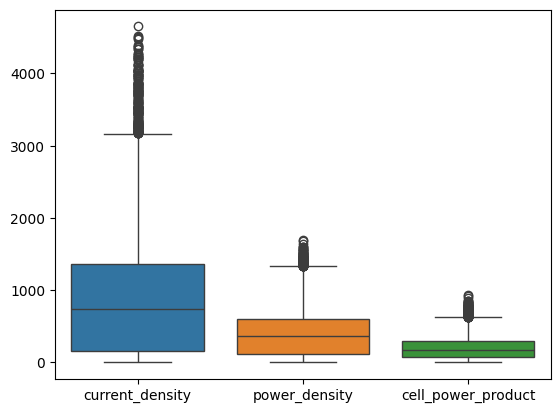

In [ ]:
sns.boxplot(data=dados_processados.loc[:,['current_density', 'power_density', 'cell_power_product']])  # Boxplot para visualizar outliers

In [ ]:
dadinho = dados_processados.loc[:,['current_density', 'power_density',
                               'cell_power_product']].copy()

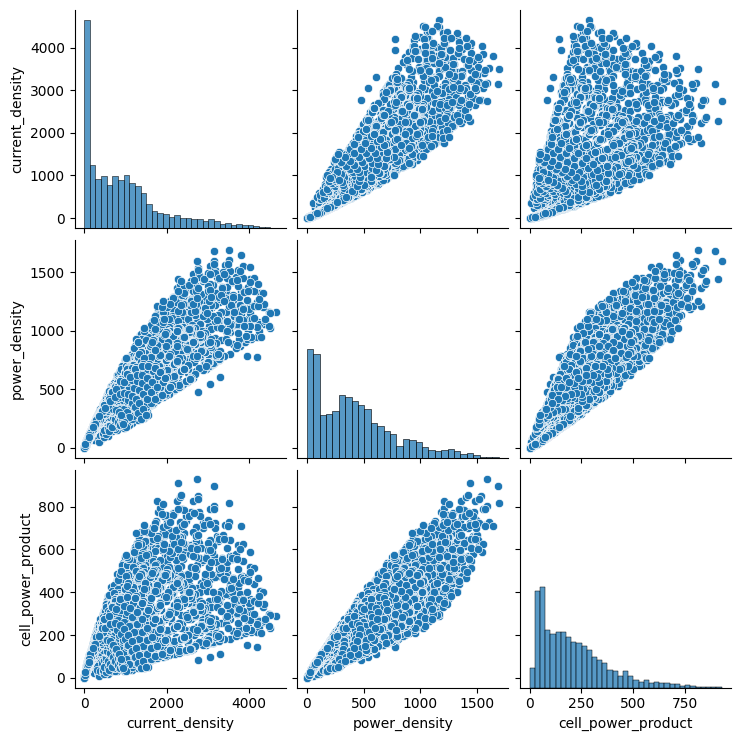

In [ ]:
sns.pairplot(dadinho.iloc[:,:])

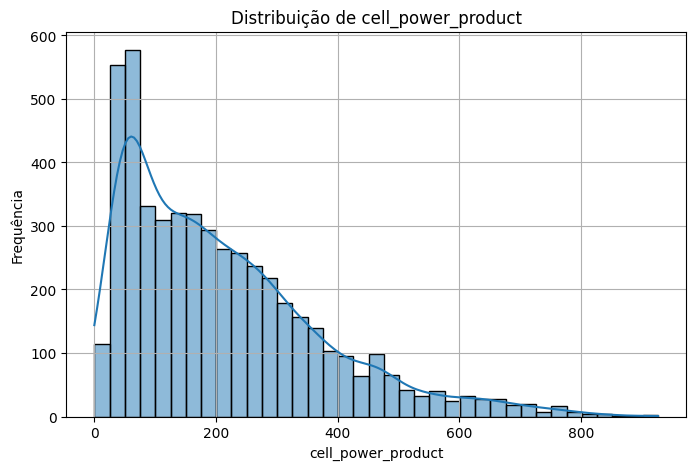

In [ ]:
# Histograma da variável de saída
plt.figure(figsize=(8, 5))
sns.histplot(dados_processados['cell_power_product'], kde=True)
plt.title('Distribuição de cell_power_product')
plt.xlabel('cell_power_product')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

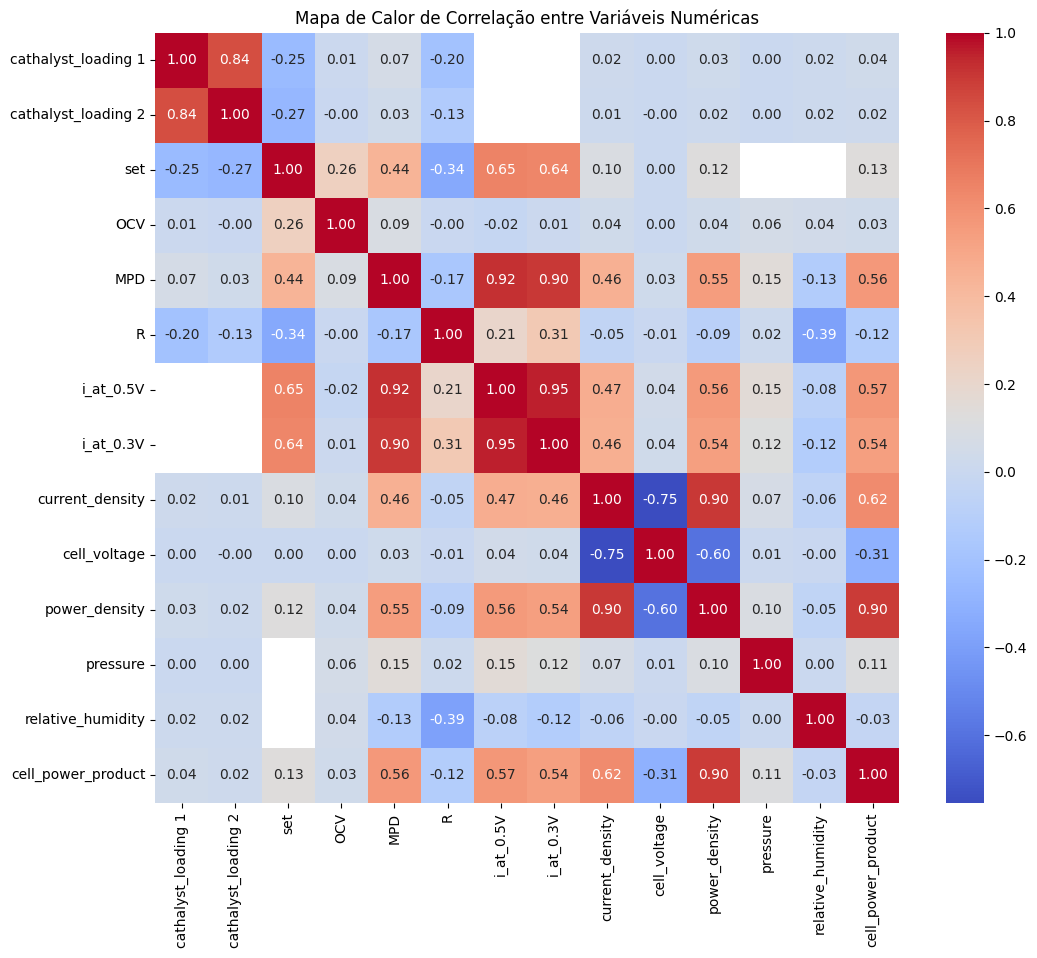

In [ ]:
# Mapa de calor de correlação para variáveis numéricas
plt.figure(figsize=(12, 10))
sns.heatmap(dados_processados.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlação entre Variáveis Numéricas')
plt.show()

In [ ]:
# prompt: Considerando o dataframe dados_recorte fazer uma análise de normalidade para todas as colunas e apresentar o resultado na forma de umdicionário com todos os índices de normalidade ordenadas da menor para a maior. Utilizar como índice de normalidade o Shapiro-Wilk

import numpy as np
# Selecionar apenas as colunas numéricas para o teste de normalidade
dados_numericos = dados_processados.select_dtypes(include=np.number)

# Inicializar um dicionário para armazenar os resultados do teste de Shapiro-Wilk
shapiro_results = {}

# Iterar sobre cada coluna numérica
for column in dados_numericos.columns:
  # Realizar o teste de Shapiro-Wilk
  # stats.shapiro retorna (estatística_do_teste, p_valor)
  stat, p_value = stats.shapiro(dados_numericos[column].dropna()) # Remover NaNs antes do teste
  # Armazenar o p_valor no dicionário
  shapiro_results[column] = p_value

# Ordenar o dicionário pelos p_valores (índices de normalidade) em ordem crescente
sorted_shapiro_results = dict(sorted(shapiro_results.items(), key=lambda item: item[1]))

# Imprimir o dicionário ordenado
print("Resultados do Teste de Shapiro-Wilk (p-valor) ordenados (menor para maior):")
print(sorted_shapiro_results)

# Interpretação (opcional):
# Geralmente, se p-valor > 0.05, não rejeitamos a hipótese nula de que os dados são normais.
# Se p-valor <= 0.05, rejeitamos a hipótese nula, sugerindo que os dados não são normais.
print("\nInterpretação (geralmente com alpha=0.05):")
for col, pval in sorted_shapiro_results.items():
    if pval > 0.05:
        print(f"Coluna '{col}': p-valor = {pval:.4f} > 0.05. Não há evidência forte para rejeitar a normalidade.")
    else:
        print(f"Coluna '{col}': p-valor = {pval:.4f} <= 0.05. Há evidência para rejeitar a normalidade.")


Resultados do Teste de Shapiro-Wilk (p-valor) ordenados (menor para maior):
{'OCV': np.float64(4.462829920299416e-82), 'cathalyst_loading 1': np.float64(8.28791385048241e-73), 'cathalyst_loading 2': np.float64(5.203749757422401e-72), 'relative_humidity': np.float64(1.7691506732782455e-55), 'pressure': np.float64(1.257853066687492e-54), 'current_density': np.float64(1.4355252142562244e-54), 'cell_power_product': np.float64(6.7741031695272576e-49), 'power_density': np.float64(7.496710734917047e-47), 'i_at_0.3V': np.float64(3.71727647817025e-44), 'MPD': np.float64(3.205299026269513e-43), 'i_at_0.5V': np.float64(4.2081286189716094e-40), 'R': np.float64(3.0558412888662703e-37), 'cell_voltage': np.float64(3.821474717401154e-36), 'set': np.float64(2.0015812717256027e-27)}

Interpretação (geralmente com alpha=0.05):
Coluna 'OCV': p-valor = 0.0000 <= 0.05. Há evidência para rejeitar a normalidade.
Coluna 'cathalyst_loading 1': p-valor = 0.0000 <= 0.05. Há evidência para rejeitar a normalidade.


## Definição de Variáveis e Divisão dos Dados

Aqui, definimos as features (fatores) e a variável alvo (resposta). A divisão train_test_split será feita mantendo a estratificação pela coluna 'type'.

In [ ]:
# Definir a variável de saída (resposta)
resposta = ['cell_power_product']

In [ ]:
# Definir as features (fatores) - todas as colunas exceto a resposta
fatores = [col for col in dados_processados.columns if col not in resposta]

In [ ]:
X = dados_processados[fatores].copy()
Y = dados_processados[resposta].copy()

In [ ]:
# Identificar colunas numéricas e categóricas
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

In [ ]:
print(f"\nVariáveis Numéricas: {numerical_features}")
print(f"Variáveis Categóricas: {categorical_features}")


Variáveis Numéricas: ['cathalyst_loading 1', 'cathalyst_loading 2', 'set', 'OCV', 'MPD', 'R', 'i_at_0.5V', 'i_at_0.3V', 'current_density', 'cell_voltage', 'power_density', 'pressure', 'relative_humidity']
Variáveis Categóricas: ['type']


Divisão dos dados em treino e teste, estratificando por 'type'


In [ ]:
# Certifique-se de que 'type' existe e tem valores suficientes para estratificação
if 'type' in X.columns:
    X_treino, X_teste, Y_treino, Y_teste = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=X['type']
    )
else:
    print("WARNING: Coluna 'type' não encontrada para estratificação. Dividindo sem estratificação.")
    X_treino, X_teste, Y_treino, Y_teste = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

In [ ]:
print(f"\nShape de X_treino: {X_treino.shape}")
print(f"Shape de X_teste: {X_teste.shape}")
print(f"Shape de Y_treino: {Y_treino.shape}")
print(f"Shape de Y_teste: {Y_teste.shape}")


Shape de X_treino: (4004, 14)
Shape de X_teste: (1001, 14)
Shape de Y_treino: (4004, 1)
Shape de Y_teste: (1001, 1)


 Escalonamento da Variável de Saída (Y)

In [ ]:
# Inicializar o scaler para a variável Y
scaler_y = MinMaxScaler()

In [ ]:
# Ajustar e transformar Y de treino e Y de teste
Y_treino_scaled = scaler_y.fit_transform(Y_treino)
Y_teste_scaled = scaler_y.transform(Y_teste)

print(f"\nVariável de saída Y escalonada. Nova escala de Y_treino: [{Y_treino_scaled.min()}, {Y_treino_scaled.max()}]")


Variável de saída Y escalonada. Nova escala de Y_treino: [0.0, 1.0]


## Criação de Pipelines de Pré-processamento

Esta é uma parte crucial para organizar o fluxo de trabalho. Usaremos ColumnTransformer para aplicar diferentes transformações a diferentes tipos de colunas (numéricas e categóricas) e Pipeline para encadear essas transformações com o modelo.

In [ ]:
# Pipeline para features numéricas: imputação com a média e escalonamento Min-Max
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])


In [ ]:
# Pipeline para features categóricas: imputação com a moda e One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# Combinar os transformadores usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Para obter os nomes das features transformadas (do preprocessor base)
preprocessor.fit(X_treino)
feature_names_transformed = preprocessor.get_feature_names_out()

Outras engenharias de features

In [ ]:
X_treino_fe = X_treino.copy()
X_teste_fe = X_teste.copy()

In [ ]:
epsilon = 1e-6

In [ ]:
#Transformação Logarítmica para Features Skewed (se aplicável, verifique a distribuição das suas features)
# Exemplo: Se 'current_density' ou 'power_density' tiverem caudas longas/skewed
for col in ['current_density', 'power_density']: # Adapte para suas colunas
    if col in X_treino_fe.columns:
        X_treino_fe[f'{col}_log'] = np.log1p(X_treino_fe[col]) # log1p é log(1+x) para lidar com zeros
        X_teste_fe[f'{col}_log'] = np.log1p(X_teste_fe[col])
        print(f"Feature '{col}_log' criada.")
    else:
        print(f"Atenção: '{col}' não encontrada para transformação logarítmica.")


Feature 'current_density_log' criada.
Feature 'power_density_log' criada.


In [ ]:
# 1. Termo de Interação entre Pressão e Umidade
if 'pressure' in X_treino_fe.columns and 'relative_humidity' in X_treino_fe.columns:
    X_treino_fe['pressure_humidity_interaction'] = X_treino_fe['pressure'] * X_treino_fe['relative_humidity']
    X_teste_fe['pressure_humidity_interaction'] = X_teste_fe['pressure'] * X_teste_fe['relative_humidity']
    #print("Feature 'pressure_humidity_interaction' criada.")
else:
    print("Atenção: 'pressure' ou 'relative_humidity' não encontradas para 'pressure_humidity_interaction'.")


In [ ]:
# 2. Termo Quadrático da Densidade de Corrente
if 'current_density' in X_treino_fe.columns:
    X_treino_fe['current_density_squared'] = X_treino_fe['current_density']**2
    X_teste_fe['current_density_squared'] = X_teste_fe['current_density']**2
    #print("Feature 'current_density_squared' criada.")
else:
    print("Atenção: 'current_density' não encontrada para 'current_density_squared'.")


In [ ]:
# 3. Interação entre Densidade de Corrente e Tensão da Célula
if 'current_density' in X_treino_fe.columns and 'cell_voltage' in X_treino_fe.columns:
    X_treino_fe['current_voltage_interaction'] = X_treino_fe['current_density'] * X_treino_fe['cell_voltage']
    X_teste_fe['current_voltage_interaction'] = X_teste_fe['current_density'] * X_teste_fe['cell_voltage']
    #print("Feature 'current_voltage_interaction' criada.")
else:
    print("Atenção: 'current_density' ou 'cell_voltage' não encontradas para 'current_voltage_interaction'.")


In [ ]:
# Atualizar a lista de features numéricas para o ColumnTransformer com as novas features
new_numerical_features = X_treino_fe.select_dtypes(include=np.number).columns.tolist()


In [ ]:
preprocessor_fe = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, new_numerical_features), # Usa a nova lista de features numéricas
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [ ]:
# Refit o preprocessor_fe com os dados de treino atualizados para pegar os novos nomes de features
preprocessor_fe.fit(X_treino_fe)
feature_names_transformed_fe = preprocessor_fe.get_feature_names_out()

In [ ]:
print("Novas features adicionadas:", list(new_numerical_features))
print(f"Número total de features (treino): {X_treino_fe.shape[1]}")

Novas features adicionadas: ['cathalyst_loading 1', 'cathalyst_loading 2', 'set', 'OCV', 'MPD', 'R', 'i_at_0.5V', 'i_at_0.3V', 'current_density', 'cell_voltage', 'power_density', 'pressure', 'relative_humidity', 'current_density_log', 'power_density_log', 'pressure_humidity_interaction', 'current_density_squared', 'current_voltage_interaction']
Número total de features (treino): 19


In [ ]:
# Dicionário para armazenar os resultados de todos os modelos
model_results = {}

## Modelagem de Regressão Linear



Agora, vamos montar um pipeline completo para a Regressão Linear, incluindo o pré-processamento.

In [ ]:
# Pipeline completo para Regressão Linear
model_linear_regression = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [ ]:
# Treinar o modelo
model_linear_regression.fit(X_treino, Y_treino_scaled.ravel())


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['cathalyst_loading 1',
                                                   'cathalyst_loading 2', 'set',
                                                   'OCV', 'MPD', 'R',
                                                   'i_at_0.5V', 'i_at_0.3V',
                                                   'current_density',
                                                   'cell_voltage',
                                                   'power_density', 'pressure',
                                                   'relative_humidity']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['type'])])),
                ('regressor', LinearRegression())])

In [ ]:
Y_pred_treino_lr_scaled = model_linear_regression.predict(X_treino)
Y_pred_teste_lr_scaled = model_linear_regression.predict(X_teste)
r2_treino_lr_scaled = r2_score(Y_treino_scaled, Y_pred_treino_lr_scaled)
mse_treino_lr_scaled = mean_squared_error(Y_treino_scaled, Y_pred_treino_lr_scaled)
r2_teste_lr_scaled = r2_score(Y_teste_scaled, Y_pred_teste_lr_scaled)
mse_teste_lr_scaled = mean_squared_error(Y_teste_scaled, Y_pred_teste_lr_scaled)
Y_pred_treino_lr_original = scaler_y.inverse_transform(Y_pred_treino_lr_scaled.reshape(-1, 1))
Y_pred_teste_lr_original = scaler_y.inverse_transform(Y_pred_teste_lr_scaled.reshape(-1, 1))
r2_treino_lr_original = r2_score(Y_treino, Y_pred_treino_lr_original)
mse_treino_lr_original = mean_squared_error(Y_treino, Y_pred_treino_lr_original)
r2_teste_lr_original = r2_score(Y_teste, Y_pred_teste_lr_original)
mse_teste_lr_original = mean_squared_error(Y_teste, Y_pred_teste_lr_original)
model_results['Linear Regression'] = {
    'R2 (Treino - Escalonado)': r2_treino_lr_scaled, 'MSE (Treino - Escalonado)': mse_treino_lr_scaled,
    'R2 (Teste - Escalonado)': r2_teste_lr_scaled, 'MSE (Teste - Escalonado)': mse_teste_lr_scaled,
    'R2 (Treino - Original)': r2_treino_lr_original, 'MSE (Treino - Original)': mse_treino_lr_original,
    'R2 (Teste - Original)': r2_teste_lr_original, 'MSE (Teste - Original)': mse_teste_lr_original
}


model_results

{'Linear Regression': {'R2 (Treino - Escalonado)': 0.9828511256491794,
  'MSE (Treino - Escalonado)': 0.000522925526134349,
  'R2 (Teste - Escalonado)': 0.9831962815676744,
  'MSE (Teste - Escalonado)': 0.0005215315799358294,
  'R2 (Treino - Original)': 0.9828511256491794,
  'MSE (Treino - Original)': 449.33598480037335,
  'R2 (Teste - Original)': 0.9831962815676744,
  'MSE (Teste - Original)': 448.13820393757857}}

In [ ]:
# Para obter os nomes das features após o ColumnTransformer e OneHotEncoder
# Crie um DataFrame temporário para ver os nomes das colunas transformadas
preprocessor.fit(X_treino) # Fit o preprocessor nos dados de treino
feature_names_transformed = preprocessor.get_feature_names_out()

In [ ]:
# Obter os coeficientes do modelo de regressão linear
coefficients = model_linear_regression.named_steps['regressor'].coef_[0]

In [ ]:
# Criar um DataFrame para exibir os coeficientes
coefficients_df = pd.DataFrame({
    'Feature': feature_names_transformed,
    'Coefficient': coefficients
})
coefficients_df['Absolute_Coefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute_Coefficient', ascending=False)

print("\nCoeficientes do Modelo de Regressão Linear (por importância absoluta):")
print(coefficients_df.head(10)) # Exibir os 10 mais importantes


Coeficientes do Modelo de Regressão Linear (por importância absoluta):
                    Feature  Coefficient  Absolute_Coefficient
0  num__cathalyst_loading 1     0.000649              0.000649
1  num__cathalyst_loading 2     0.000649              0.000649
2                  num__set     0.000649              0.000649
3                  num__OCV     0.000649              0.000649
4                  num__MPD     0.000649              0.000649
5                    num__R     0.000649              0.000649
6            num__i_at_0.5V     0.000649              0.000649
7            num__i_at_0.3V     0.000649              0.000649
8      num__current_density     0.000649              0.000649
9         num__cell_voltage     0.000649              0.000649


## Regressão com modelos tipo Árvore de Decisão

In [ ]:
# Pipeline completo para RandomForestRegressor
model_random_forest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_estimators=500))
])
model_random_forest.fit(X_treino, Y_treino_scaled.ravel())

# Avaliar o modelo
Y_pred_treino_rf_scaled = model_random_forest.predict(X_treino)
Y_pred_teste_rf_scaled = model_random_forest.predict(X_teste)
r2_treino_rf_scaled = r2_score(Y_treino_scaled, Y_pred_treino_rf_scaled)
mse_treino_rf_scaled = mean_squared_error(Y_treino_scaled, Y_pred_treino_rf_scaled)
r2_teste_rf_scaled = r2_score(Y_teste_scaled, Y_pred_teste_rf_scaled)
mse_teste_rf_scaled = mean_squared_error(Y_teste_scaled, Y_pred_teste_rf_scaled)
Y_pred_treino_rf_original = scaler_y.inverse_transform(Y_pred_treino_rf_scaled.reshape(-1, 1))
Y_pred_teste_rf_original = scaler_y.inverse_transform(Y_pred_teste_rf_scaled.reshape(-1, 1))
r2_treino_rf_original = r2_score(Y_treino, Y_pred_treino_rf_original)
mse_treino_rf_original = mean_squared_error(Y_treino, Y_pred_treino_rf_original)
r2_teste_rf_original = r2_score(Y_teste, Y_pred_teste_rf_original)
mse_teste_rf_original = mean_squared_error(Y_teste, Y_pred_teste_rf_original)
model_results['RandomForestRegressor'] = {
    'R2 (Treino - Escalonado)': r2_treino_rf_scaled, 'MSE (Treino - Escalonado)': mse_treino_rf_scaled,
    'R2 (Teste - Escalonado)': r2_teste_rf_scaled, 'MSE (Teste - Escalonado)': mse_teste_rf_scaled,
    'R2 (Treino - Original)': r2_treino_rf_original, 'MSE (Treino - Original)': mse_treino_rf_original,
    'R2 (Teste - Original)': r2_teste_rf_original, 'MSE (Teste - Original)': mse_teste_rf_original
}

model_results


{'Linear Regression': {'R2 (Treino - Escalonado)': 0.9828511256491794,
  'MSE (Treino - Escalonado)': 0.000522925526134349,
  'R2 (Teste - Escalonado)': 0.9831962815676744,
  'MSE (Teste - Escalonado)': 0.0005215315799358294,
  'R2 (Treino - Original)': 0.9828511256491794,
  'MSE (Treino - Original)': 449.33598480037335,
  'R2 (Teste - Original)': 0.9831962815676744,
  'MSE (Teste - Original)': 448.13820393757857},
 'RandomForestRegressor': {'R2 (Treino - Escalonado)': 0.9998121561170698,
  'MSE (Treino - Escalonado)': 5.727977201471853e-06,
  'R2 (Teste - Escalonado)': 0.9983637933083509,
  'MSE (Teste - Escalonado)': 5.07824184530344e-05,
  'R2 (Treino - Original)': 0.9998121561170698,
  'MSE (Treino - Original)': 4.921898335626835,
  'R2 (Teste - Original)': 0.9983637933083509,
  'MSE (Teste - Original)': 43.63598039441741}}

In [ ]:
# Visualizar a importância das features para RandomForest
# Obter a importância das features do regressor
feature_importances_rf = model_random_forest.named_steps['regressor'].feature_importances_

# Criar um DataFrame para exibir a importância das features
# É crucial que feature_names_transformed esteja disponível. Se não estiver,
# certifique-se de que a célula com 'preprocessor.get_feature_names_out()' foi executada.
feature_importance_df_rf = pd.DataFrame({
    'Feature': feature_names_transformed,
    'Importance': feature_importances_rf
})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

print("\nImportância das Features no RandomForestRegressor:")
print(feature_importance_df_rf.head(10))


Importância das Features no RandomForestRegressor:
                       Feature  Importance
10          num__power_density    0.751021
9            num__cell_voltage    0.157140
4                     num__MPD    0.088106
8         num__current_density    0.001506
5                       num__R    0.000476
3                     num__OCV    0.000373
6               num__i_at_0.5V    0.000353
12      num__relative_humidity    0.000293
7               num__i_at_0.3V    0.000203
14  cat__type_Polarization 1.a    0.000135


## Regressão por XGBoost

In [ ]:
# Pipeline completo para XGBoost
model_xgboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100))
])

# Treinar o modelo
model_xgboost.fit(X_treino, Y_treino_scaled.ravel())

# Avaliar o modelo
Y_pred_treino_xgb_scaled = model_xgboost.predict(X_treino)
Y_pred_teste_xgb_scaled = model_xgboost.predict(X_teste)
r2_treino_xgb_scaled = r2_score(Y_treino_scaled, Y_pred_treino_xgb_scaled)
mse_treino_xgb_scaled = mean_squared_error(Y_treino_scaled, Y_pred_treino_xgb_scaled)
r2_teste_xgb_scaled = r2_score(Y_teste_scaled, Y_pred_teste_xgb_scaled)
mse_teste_xgb_scaled = mean_squared_error(Y_teste_scaled, Y_pred_teste_xgb_scaled)
Y_pred_treino_xgb_original = scaler_y.inverse_transform(Y_pred_treino_xgb_scaled.reshape(-1, 1))
Y_pred_teste_xgb_original = scaler_y.inverse_transform(Y_pred_teste_xgb_scaled.reshape(-1, 1))
r2_treino_xgb_original = r2_score(Y_treino, Y_pred_treino_xgb_original)
mse_treino_xgb_original = mean_squared_error(Y_treino, Y_pred_treino_xgb_original)
r2_teste_xgb_original = r2_score(Y_teste, Y_pred_teste_xgb_original)
mse_teste_xgb_original = mean_squared_error(Y_teste, Y_pred_teste_xgb_original)
model_results['XGBoost (Base)'] = {
    'R2 (Treino - Escalonado)': r2_treino_xgb_scaled, 'MSE (Treino - Escalonado)': mse_treino_xgb_scaled,
    'R2 (Teste - Escalonado)': r2_teste_xgb_scaled, 'MSE (Teste - Escalonado)': mse_teste_xgb_scaled,
    'R2 (Treino - Original)': r2_treino_xgb_original, 'MSE (Treino - Original)': mse_treino_xgb_original,
    'R2 (Teste - Original)': r2_teste_xgb_original, 'MSE (Teste - Original)': mse_teste_xgb_original
}


model_results


{'Linear Regression': {'R2 (Treino - Escalonado)': 0.9828511256491794,
  'MSE (Treino - Escalonado)': 0.000522925526134349,
  'R2 (Teste - Escalonado)': 0.9831962815676744,
  'MSE (Teste - Escalonado)': 0.0005215315799358294,
  'R2 (Treino - Original)': 0.9828511256491794,
  'MSE (Treino - Original)': 449.33598480037335,
  'R2 (Teste - Original)': 0.9831962815676744,
  'MSE (Teste - Original)': 448.13820393757857},
 'RandomForestRegressor': {'R2 (Treino - Escalonado)': 0.9998121561170698,
  'MSE (Treino - Escalonado)': 5.727977201471853e-06,
  'R2 (Teste - Escalonado)': 0.9983637933083509,
  'MSE (Teste - Escalonado)': 5.07824184530344e-05,
  'R2 (Treino - Original)': 0.9998121561170698,
  'MSE (Treino - Original)': 4.921898335626835,
  'R2 (Teste - Original)': 0.9983637933083509,
  'MSE (Teste - Original)': 43.63598039441741},
 'XGBoost (Base)': {'R2 (Treino - Escalonado)': 0.9998780257947968,
  'MSE (Treino - Escalonado)': 3.7193942952662865e-06,
  'R2 (Teste - Escalonado)': 0.997936

## Modelo de NN para Regressão

In [ ]:
# Transformar os dados de X usando o preprocessor base antes de passar para a NN
X_treino_processed_base = preprocessor.fit_transform(X_treino)
X_teste_processed_base = preprocessor.transform(X_teste)

# Definir a arquitetura da Rede Neural
model_keras = Sequential([
    Dense(64, activation='relu', input_shape=(X_treino_processed_base.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# Compilar o modelo
model_keras.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')



In [ ]:
# Treinar o modelo
history = model_keras.fit(X_treino_processed_base, Y_treino_scaled,
                          epochs=500, batch_size=32, validation_split=0.2, verbose=0)
history


In [ ]:
# Avaliar o modelo
Y_pred_treino_keras_scaled = model_keras.predict(X_treino_processed_base)
Y_pred_teste_keras_scaled = model_keras.predict(X_teste_processed_base)
r2_treino_keras_scaled = r2_score(Y_treino_scaled, Y_pred_treino_keras_scaled)
mse_treino_keras_scaled = mean_squared_error(Y_treino_scaled, Y_pred_treino_keras_scaled)
r2_teste_keras_scaled = r2_score(Y_teste_scaled, Y_pred_teste_keras_scaled)
mse_teste_keras_scaled = mean_squared_error(Y_teste_scaled, Y_pred_teste_keras_scaled)
Y_pred_treino_keras_original = scaler_y.inverse_transform(Y_pred_treino_keras_scaled.reshape(-1,1))
Y_pred_teste_keras_original = scaler_y.inverse_transform(Y_pred_teste_keras_scaled.reshape(-1,1))
r2_treino_keras_original = r2_score(Y_treino, Y_pred_treino_keras_original)
mse_treino_keras_original = mean_squared_error(Y_treino, Y_pred_treino_keras_original)
r2_teste_keras_original = r2_score(Y_teste, Y_pred_teste_keras_original)
mse_teste_keras_original = mean_squared_error(Y_teste, Y_pred_teste_keras_original)
model_results['Keras Neural Network'] = {
    'R2 (Treino - Escalonado)': r2_treino_keras_scaled, 'MSE (Treino - Escalonado)': mse_treino_keras_scaled,
    'R2 (Teste - Escalonado)': r2_teste_keras_scaled, 'MSE (Teste - Escalonado)': mse_teste_keras_scaled,
    'R2 (Treino - Original)': r2_treino_keras_original, 'MSE (Treino - Original)': mse_treino_keras_original,
    'R2 (Teste - Original)': r2_teste_keras_original, 'MSE (Teste - Original)': mse_teste_keras_original
}

model_results

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


{'Linear Regression': {'R2 (Treino - Escalonado)': 0.9828511256491794,
  'MSE (Treino - Escalonado)': 0.000522925526134349,
  'R2 (Teste - Escalonado)': 0.9831962815676744,
  'MSE (Teste - Escalonado)': 0.0005215315799358294,
  'R2 (Treino - Original)': 0.9828511256491794,
  'MSE (Treino - Original)': 449.33598480037335,
  'R2 (Teste - Original)': 0.9831962815676744,
  'MSE (Teste - Original)': 448.13820393757857},
 'RandomForestRegressor': {'R2 (Treino - Escalonado)': 0.9998121561170698,
  'MSE (Treino - Escalonado)': 5.727977201471853e-06,
  'R2 (Teste - Escalonado)': 0.9983637933083509,
  'MSE (Teste - Escalonado)': 5.07824184530344e-05,
  'R2 (Treino - Original)': 0.9998121561170698,
  'MSE (Treino - Original)': 4.921898335626835,
  'R2 (Teste - Original)': 0.9983637933083509,
  'MSE (Teste - Original)': 43.63598039441741},
 'XGBoost (Base)': {'R2 (Treino - Escalonado)': 0.9998780257947968,
  'MSE (Treino - Escalonado)': 3.7193942952662865e-06,
  'R2 (Teste - Escalonado)': 0.997936

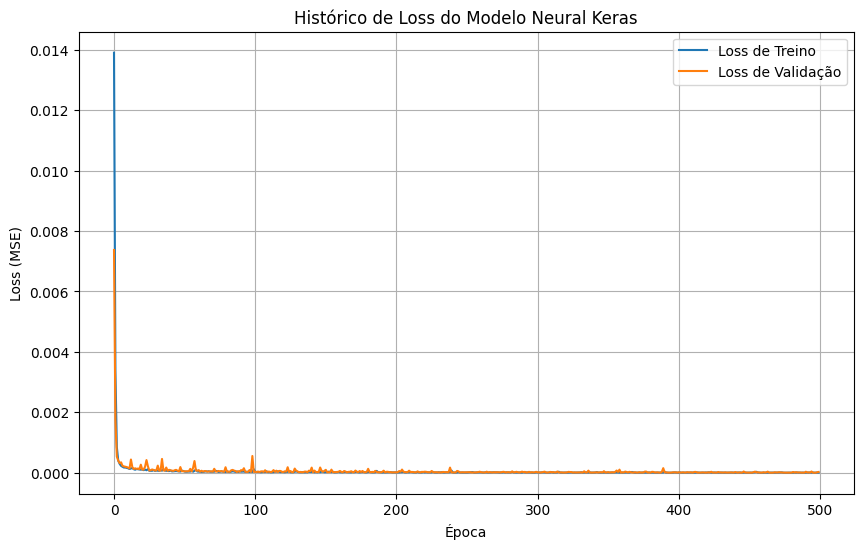

In [ ]:
# Plotar histórico de loss (já está usando o loss do treinamento que é baseado em Y_treino_scaled)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Loss de Treino')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.title('Histórico de Loss do Modelo Neural Keras')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()



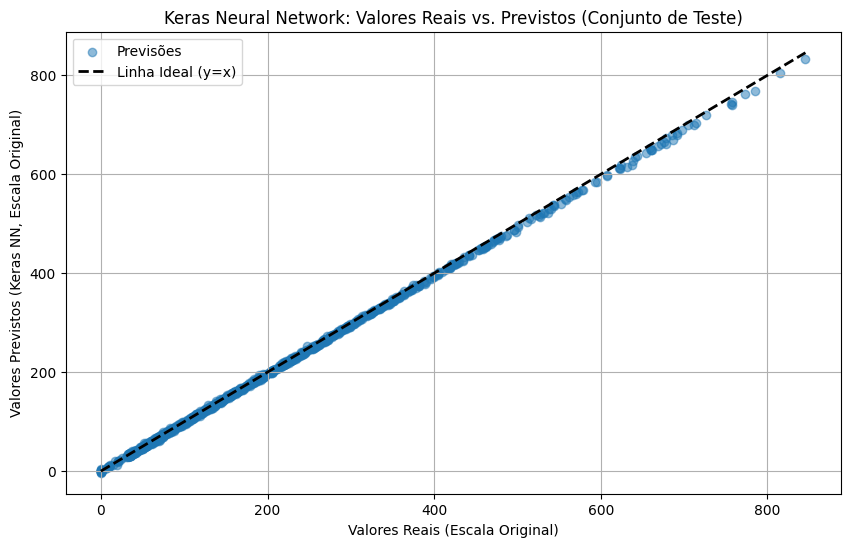

In [ ]:
# Plotar valores reais vs previstos (na escala ORIGINAL)
plt.figure(figsize=(10, 6))
plt.scatter(Y_teste, Y_pred_teste_keras_original, alpha=0.5, label='Previsões')
plt.plot([Y_teste.min(), Y_teste.max()], [Y_teste.min(), Y_teste.max()], 'k--', lw=2, label='Linha Ideal (y=x)')
plt.xlabel('Valores Reais (Escala Original)')
plt.ylabel('Valores Previstos (Keras NN, Escala Original)')
plt.title('Keras Neural Network: Valores Reais vs. Previstos (Conjunto de Teste)')
plt.legend()
plt.grid(True)
plt.show()

## Validação Cruzada e a Otimização de Hiperparâmetros

In [ ]:
# 1. Definir o Pipeline completo para o XGBoost, incluindo o pré-processador
pipeline_xgb_fe = Pipeline(steps=[
    ('preprocessor', preprocessor_fe), # Usa o preprocessor_fe (com novas features)
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

In [ ]:
# 2. Definir o Grid de Hiperparâmetros para otimização
# Param_grid expandido - Você pode ajustar esses valores
param_grid_xgb = {
    'regressor__n_estimators': [100, 200, 300, 400], # Mais árvores
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.15], # Mais opções de learning rate
    'regressor__max_depth': [3, 5, 7, 9], # Mais opções de profundidade
    'regressor__subsample': [0.7, 0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'regressor__gamma': [0, 0.1, 0.2] # Adicionando gamma
}

In [ ]:
# 3. Configurar o GridSearchCV
# cv=5 significa 5-fold cross-validation
# scoring='neg_mean_squared_error' para otimizar o MSE (o GridSearchCV tenta maximizar, então negamos)
# n_jobs=-1 usa todos os núcleos da CPU para paralelizar a busca
grid_search_xgb_fe = GridSearchCV(
    estimator=pipeline_xgb_fe,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0,
    return_train_score=True
)


In [ ]:
# 4. Executar a Busca no Grid de Hiperparâmetros
grid_search_xgb_fe.fit(X_treino_fe, Y_treino_scaled.ravel()) # Usa X_treino_fe

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['cathalyst_loading '
                                                                          '1',
                                                                          'cathalyst_loading '
                                                                          '2',
                                                                          'set',
                                                                          'OCV',
                                                                          'MPD',
                                                                          'R',
                                                                          'i_at_0.5V',
                                                                          'i_at_0.3V',
                                                                          'current_density',
                                                                          'cell_voltage',
                                                                          'power_density',
                                                                          'pressure',
                                                                          'r...
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'regressor__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
                         'regressor__gamma': [0, 0.1, 0.2],
                         'regressor__learning_rate': [0.01, 0.05, 0.1, 0.15],
                         'regressor__max_depth': [3, 5, 7, 9],
                         'regressor__n_estimators': [100, 200, 300, 400],
                         'regressor__subsample': [0.7, 0.8, 0.9, 1.0]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
# 5. Imprimir os melhores parâmetros e a melhor pontuação
print("\n--- Melhores Hiperparâmetros para XGBoost (Validação Cruzada) com Novas Features ---")
print(f"Melhor pontuação (neg_mean_squared_error): {grid_search_xgb_fe.best_score_:.4f}")
print(f"Melhores parâmetros: {grid_search_xgb_fe.best_params_}")


--- Melhores Hiperparâmetros para XGBoost (Validação Cruzada) com Novas Features ---
Melhor pontuação (neg_mean_squared_error): -0.0000
Melhores parâmetros: {'regressor__colsample_bytree': 1.0, 'regressor__gamma': 0, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 7, 'regressor__n_estimators': 400, 'regressor__subsample': 0.7}


In [ ]:
# O melhor modelo encontrado pelo GridSearchCV
best_xgb_model_fe = grid_search_xgb_fe.best_estimator_

In [ ]:
# Avaliar o melhor modelo no conjunto de teste com novas features
Y_pred_treino_best_xgb_fe_scaled = best_xgb_model_fe.predict(X_treino_fe)
Y_pred_teste_best_xgb_fe_scaled = best_xgb_model_fe.predict(X_teste_fe)

r2_treino_best_xgb_fe_scaled = r2_score(Y_treino_scaled, Y_pred_treino_best_xgb_fe_scaled)
mse_treino_best_xgb_fe_scaled = mean_squared_error(Y_treino_scaled, Y_pred_treino_best_xgb_fe_scaled)
r2_teste_best_xgb_fe_scaled = r2_score(Y_teste_scaled, Y_pred_teste_best_xgb_fe_scaled)
mse_teste_best_xgb_fe_scaled = mean_squared_error(Y_teste_scaled, Y_pred_teste_best_xgb_fe_scaled)

Y_pred_treino_best_xgb_fe_original = scaler_y.inverse_transform(Y_pred_treino_best_xgb_fe_scaled.reshape(-1, 1))
Y_pred_teste_best_xgb_fe_original = scaler_y.inverse_transform(Y_pred_teste_best_xgb_fe_scaled.reshape(-1, 1))

r2_treino_best_xgb_fe_original = r2_score(Y_treino, Y_pred_treino_best_xgb_fe_original)
mse_treino_best_xgb_fe_original = mean_squared_error(Y_treino, Y_pred_treino_best_xgb_fe_original)
r2_teste_best_xgb_fe_original = r2_score(Y_teste, Y_pred_teste_best_xgb_fe_original)
mse_teste_best_xgb_fe_original = mean_squared_error(Y_teste, Y_pred_teste_best_xgb_fe_original)

model_results['XGBoost (Otimizado + FE)'] = {
    'R2 (Treino - Escalonado)': r2_treino_best_xgb_fe_scaled,
    'MSE (Treino - Escalonado)': mse_treino_best_xgb_fe_scaled,
    'R2 (Teste - Escalonado)': r2_teste_best_xgb_fe_scaled,
    'MSE (Teste - Escalonado)': mse_teste_best_xgb_fe_scaled,
    'R2 (Treino - Original)': r2_treino_best_xgb_fe_original,
    'MSE (Treino - Original)': mse_treino_best_xgb_fe_original,
    'R2 (Teste - Original)': r2_teste_best_xgb_fe_original,
    'MSE (Teste - Original)': mse_teste_best_xgb_fe_original
}

tabela de comparação atualizada:

In [ ]:
comparison_df = pd.DataFrame(model_results).T
print(comparison_df.to_string(float_format="%.10f"))

                          R2 (Treino - Escalonado)  MSE (Treino - Escalonado)  R2 (Teste - Escalonado)  MSE (Teste - Escalonado)  R2 (Treino - Original)  MSE (Treino - Original)  R2 (Teste - Original)  MSE (Teste - Original)
Linear Regression                     0.9828511256               0.0005229255             0.9831962816              0.0005215316            0.9828511256           449.3359848004           0.9831962816          448.1382039376
RandomForestRegressor                 0.9998121561               0.0000057280             0.9983637933              0.0000507824            0.9998121561             4.9218983356           0.9983637933           43.6359803944
XGBoost (Base)                        0.9998780258               0.0000037194             0.9979362224              0.0000640528            0.9998780489             3.1959769726           0.9979362488           55.0388526917
Keras Neural Network                  0.9991590699               0.0000256427             0.99915366

## Análise de Erros

In [ ]:
Y_teste_np = Y_teste.values.ravel() if isinstance(Y_teste, pd.DataFrame) else Y_teste.ravel()
Y_pred_teste_best_xgb_fe_original_np = Y_pred_teste_best_xgb_fe_original.ravel()
residuos = Y_teste_np - Y_pred_teste_best_xgb_fe_original_np

In [ ]:
print(f"\nMédia dos Resíduos: {np.mean(residuos):.4f}")
print(f"Desvio Padrão dos Resíduos: {np.std(residuos):.4f}")
print(f"Min Resíduos: {np.min(residuos):.4f}")
print(f"Max Resíduos: {np.max(residuos):.4f}")


Média dos Resíduos: 0.0827
Desvio Padrão dos Resíduos: 5.0380
Min Resíduos: -36.1429
Max Resíduos: 41.6727


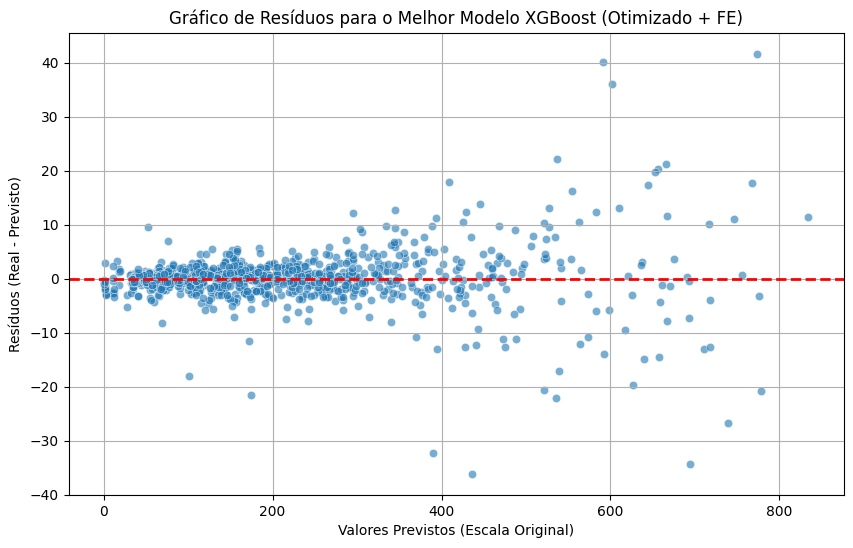

In [ ]:
# Gráfico de Resíduos (Resíduos vs. Valores Previstos)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=Y_pred_teste_best_xgb_fe_original_np, y=residuos, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Valores Previstos (Escala Original)')
plt.ylabel('Resíduos (Real - Previsto)')
plt.title('Gráfico de Resíduos para o Melhor Modelo XGBoost (Otimizado + FE)')
plt.grid(True)
plt.savefig('xgb_fe_residual_plot.png')
plt.show()

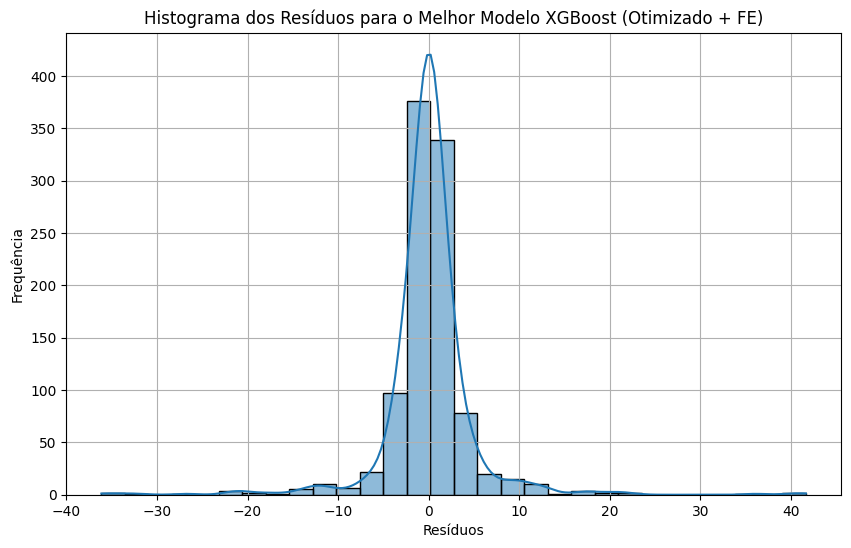

In [ ]:
# Histograma dos Resíduos
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True, bins=30)
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Histograma dos Resíduos para o Melhor Modelo XGBoost (Otimizado + FE)')
plt.grid(True)
plt.savefig('xgb_fe_residuals_histogram.png')
plt.show()

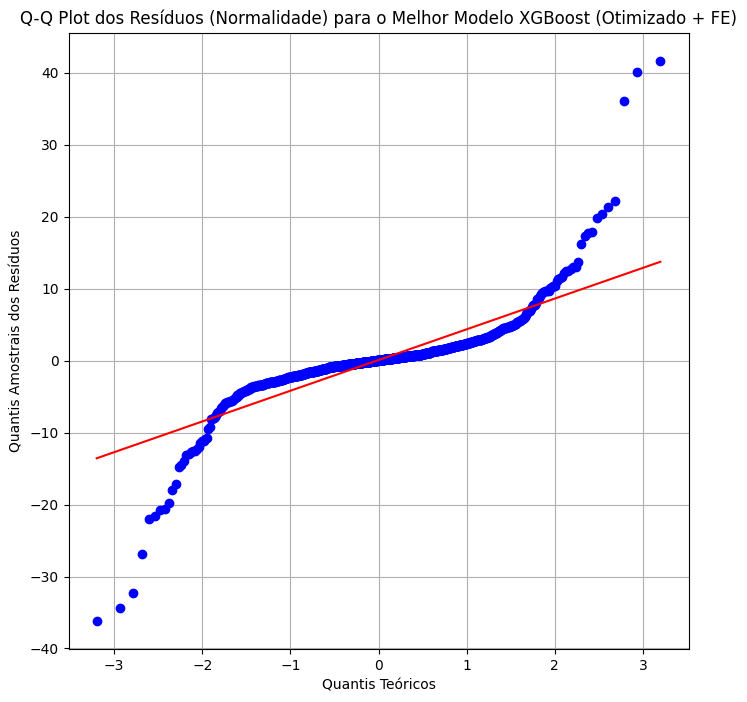

In [ ]:
# Q-Q Plot dos Resíduos
plt.figure(figsize=(8, 8))
stats.probplot(residuos, dist="norm", plot=plt)
plt.title('Q-Q Plot dos Resíduos (Normalidade) para o Melhor Modelo XGBoost (Otimizado + FE)')
plt.xlabel('Quantis Teóricos')
plt.ylabel('Quantis Amostrais dos Resíduos')
plt.grid(True)
plt.savefig('xgb_fe_residuals_qq_plot.png')
plt.show()


In [ ]:
# Identificar os pontos com os maiores erros
df_erros = pd.DataFrame({
    'Real': Y_teste_np,
    'Previsto': Y_pred_teste_best_xgb_fe_original_np,
    'Resíduo': residuos,
    'Resíduo Absoluto': np.abs(residuos)
})
erros_maiores = df_erros.sort_values(by='Resíduo Absoluto', ascending=False).head(10)
print("\n--- 10 Maiores Erros (Resíduos Absolutos) ---")
print(erros_maiores)


--- 10 Maiores Erros (Resíduos Absolutos) ---
        Real    Previsto    Resíduo  Resíduo Absoluto
259  814.580  772.907288  41.672712         41.672712
462  631.098  590.943848  40.154152         40.154152
49   399.640  435.782898 -36.142898         36.142898
279  637.981  601.888123  36.092877         36.092877
778  659.450  693.799316 -34.349316         34.349316
480  357.380  389.634369 -32.254369         32.254369
16   711.700  738.513123 -26.813123         26.813123
360  558.540  536.298157  22.241843         22.241843
677  513.420  535.447815 -22.027815         22.027815
204  153.463  175.005402 -21.542402         21.542402


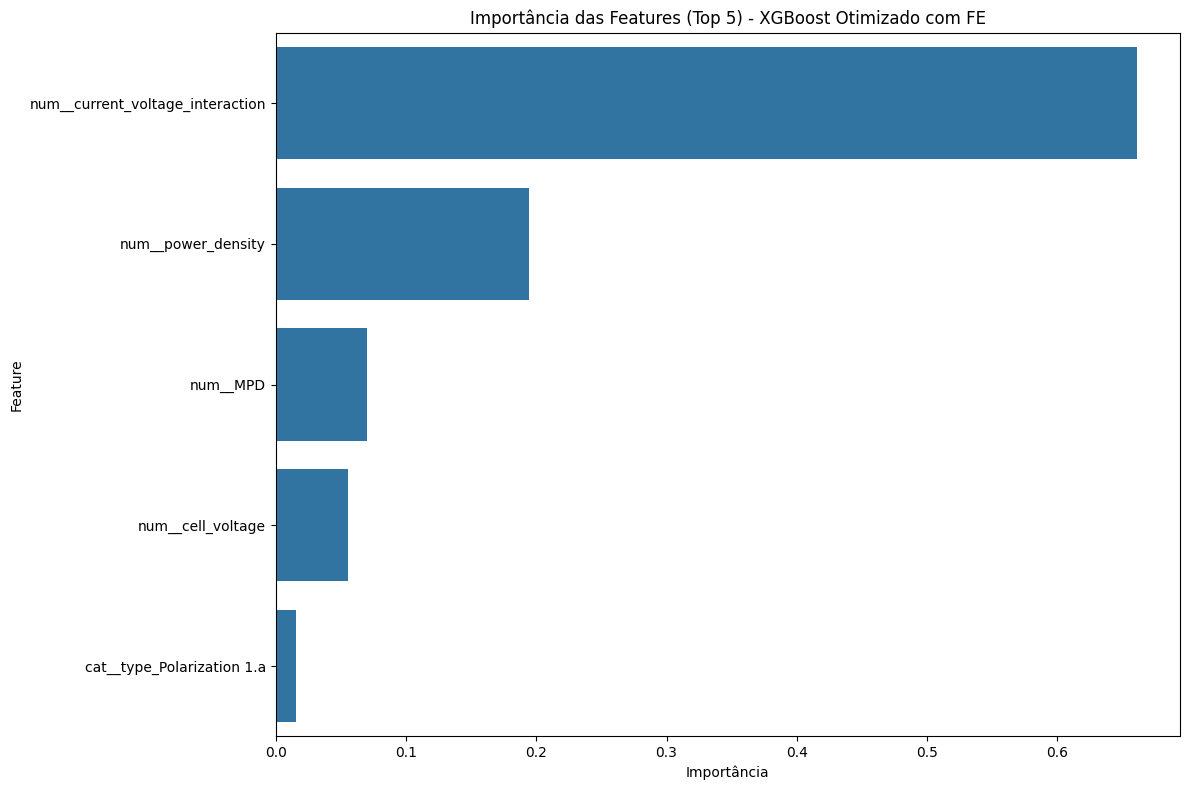

In [ ]:
feature_importances = best_xgb_model_fe.named_steps['regressor'].feature_importances_
features_df = pd.DataFrame({
    'Feature': feature_names_transformed_fe,
    'Importance': feature_importances
})
features_df = features_df.sort_values(by='Importance', ascending=False).head(5) # Top 20 features

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Importância das Features (Top 5) - XGBoost Otimizado com FE')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('xgb_fe_feature_importance.png')
plt.show()


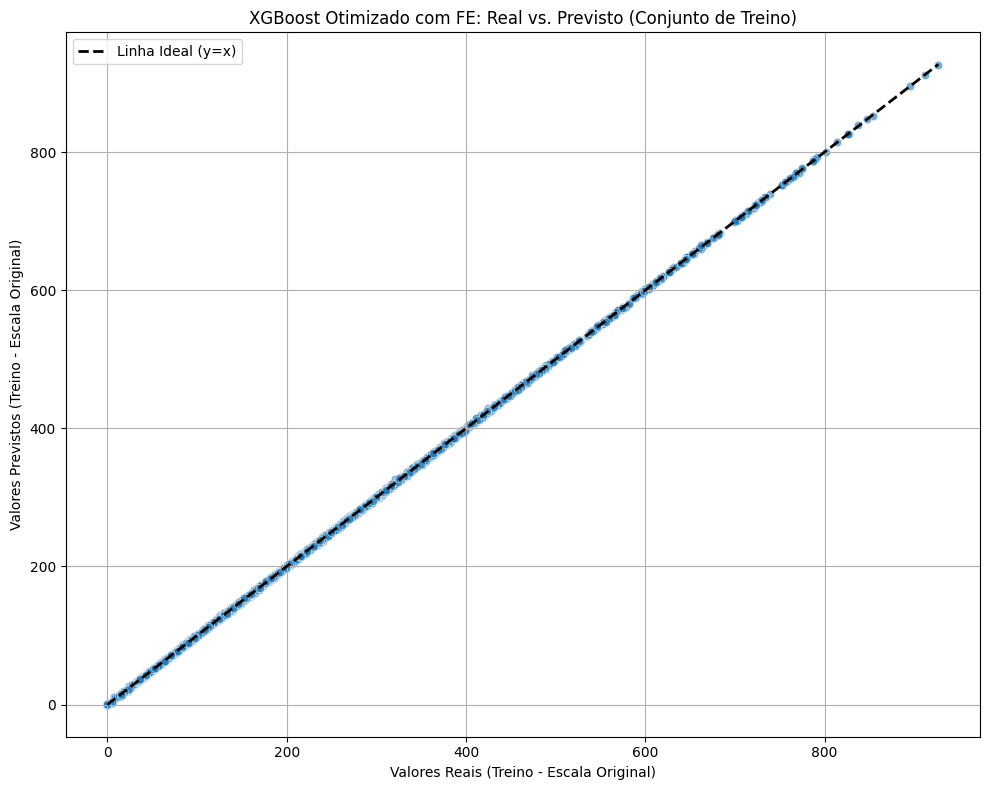

In [ ]:
# Gráfico de Valores Reais vs. Previstos (Conjunto de Treino - XGBoost Otimizado com FE)
plt.figure(figsize=(10, 8))
Y_treino_np = Y_treino.values.ravel() if isinstance(Y_treino, pd.DataFrame) else Y_treino.ravel()
Y_pred_treino_best_xgb_fe_original_np = Y_pred_treino_best_xgb_fe_original.ravel()

sns.scatterplot(x=Y_treino_np, y=Y_pred_treino_best_xgb_fe_original_np, alpha=0.6)
min_val = min(Y_treino_np.min(), Y_pred_treino_best_xgb_fe_original_np.min())
max_val = max(Y_treino_np.max(), Y_pred_treino_best_xgb_fe_original_np.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Linha Ideal (y=x)')
plt.xlabel('Valores Reais (Treino - Escala Original)')
plt.ylabel('Valores Previstos (Treino - Escala Original)')
plt.title('XGBoost Otimizado com FE: Real vs. Previsto (Conjunto de Treino)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('xgb_fe_train_actual_vs_predicted.png')
plt.show()

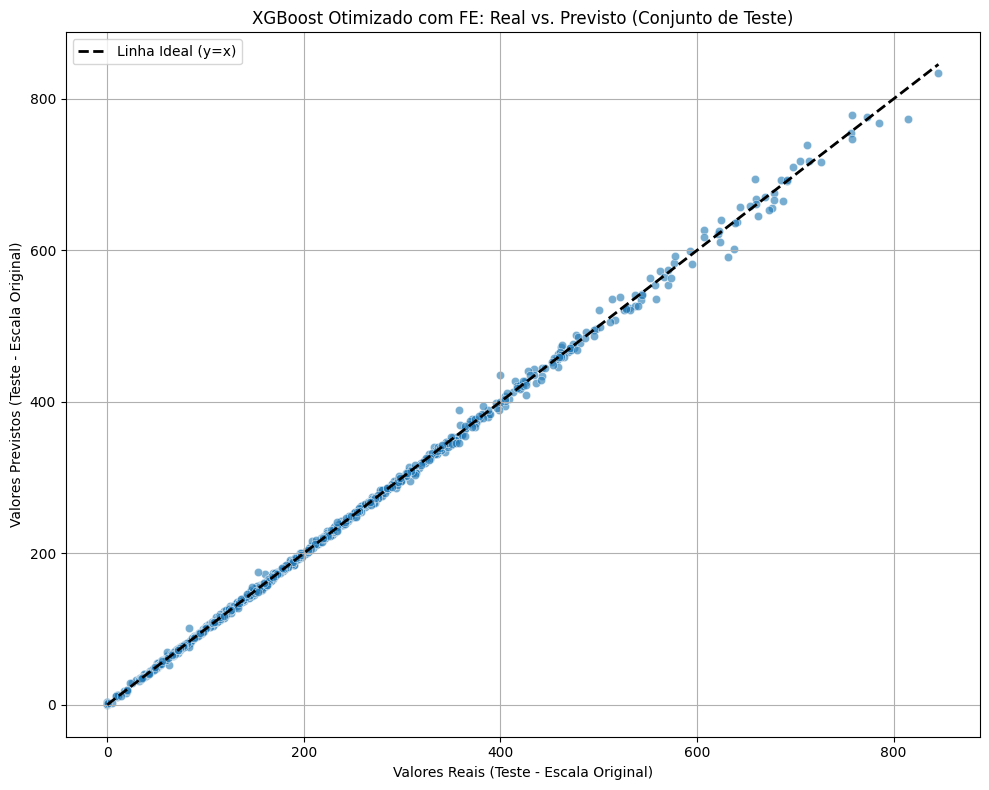

In [ ]:
# prompt: faça o gráfico de Valores Reais vs. Previstos (Conjunto de teste - XGBoost Otimizado com FE)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 8))
Y_teste_np = Y_teste.values.ravel() if isinstance(Y_teste, pd.DataFrame) else Y_teste.ravel()
Y_pred_teste_best_xgb_fe_original_np = Y_pred_teste_best_xgb_fe_original.ravel()

sns.scatterplot(x=Y_teste_np, y=Y_pred_teste_best_xgb_fe_original_np, alpha=0.6)
min_val = min(Y_teste_np.min(), Y_pred_teste_best_xgb_fe_original_np.min())
max_val = max(Y_teste_np.max(), Y_pred_teste_best_xgb_fe_original_np.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Linha Ideal (y=x)')
plt.xlabel('Valores Reais (Teste - Escala Original)')
plt.ylabel('Valores Previstos (Teste - Escala Original)')
plt.title('XGBoost Otimizado com FE: Real vs. Previsto (Conjunto de Teste)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('xgb_fe_test_actual_vs_predicted.png')
plt.show()


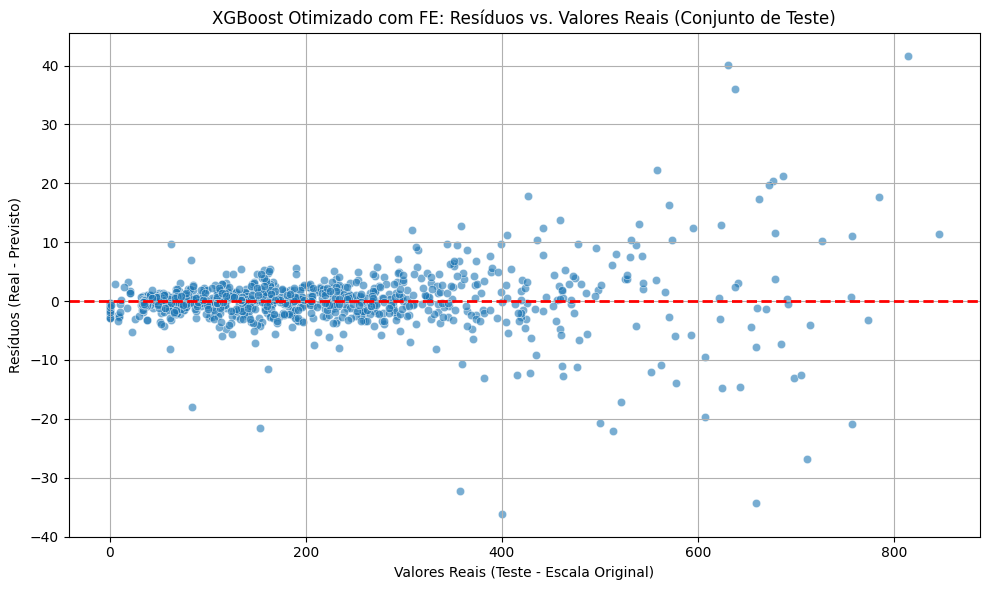

In [ ]:
# Gráfico de Resíduos vs. Valores Reais (Conjunto de Teste - XGBoost Otimizado com FE)
plt.figure(figsize=(10, 6))
residuos_teste = Y_teste_np - Y_pred_teste_best_xgb_fe_original_np # Y_teste_np e Y_pred_teste_best_xgb_fe_original_np já são definidos acima

sns.scatterplot(x=Y_teste_np, y=residuos_teste, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Valores Reais (Teste - Escala Original)')
plt.ylabel('Resíduos (Real - Previsto)')
plt.title('XGBoost Otimizado com FE: Resíduos vs. Valores Reais (Conjunto de Teste)')
plt.grid(True)
plt.tight_layout()
plt.savefig('xgb_fe_test_residuals_vs_actual.png')
plt.show()
